In [25]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [26]:
def load_and_preprocess_images(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (64, 64))  # Resize to 64x64 pixels
            images.append(img)
            labels.append(label)  # Append the label (1 for AI, 0 for real)
        else:
            print(f"Error loading image: {img_path}")  # Error handling for failed image load
    return np.array(images), np.array(labels)  # Convert lists to NumPy arrays

# Load AI-generated images and real images
ai_images, ai_labels = load_and_preprocess_images('C:/Users/deepa/OneDrive/Desktop/STGI02/real_and_ai/AiArtData', label=1)
real_images, real_labels = load_and_preprocess_images('C:/Users/deepa/OneDrive/Desktop/STGI02/real_and_ai/RealArt', label=0)

# Combine datasets (AI and Real)
X = np.vstack((ai_images, real_images))  # Combine image data vertically
y = np.hstack((ai_labels, real_labels))  # Combine labels horizontally

# Normalize images
X = X.astype('float32') / 255.0  # Normalize pixel values to [0, 1]

# Print dataset information
print(f"Total images: {X.shape[0]}")
print(f"Image shape: {X.shape[1:]}")
print(f"Total labels: {y.shape[0]}")


Error loading image: C:/Users/deepa/OneDrive/Desktop/STGI02/real_and_ai/AiArtData\img_align_celeba
Total images: 975
Image shape: (64, 64, 3)
Total labels: 975


In [27]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training images: {X_train.shape[0]}, Validation images: {X_val.shape[0]}")


Training images: 780, Validation images: 195


In [28]:
def create_cnn_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout layer
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification output
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

cnn_model = create_cnn_model()
cnn_model.summary()  # Print the model summary


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 6, 6, 128)       

In [29]:
# Create an instance of ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the data generator on the training data
datagen.fit(X_train)


In [34]:
# Train the model using the augmented data
history = cnn_model.fit(datagen.flow(X_train, y_train, batch_size=32),
                         validation_data=(X_val, y_val),
                         steps_per_epoch=len(X_train) // 32,
                         epochs=48)  # Adjust epochs as needed


Epoch 1/48
24/24 [==============================] - 4s 154ms/step - loss: 0.4509 - accuracy: 0.7861 - val_loss: 0.8887 - val_accuracy: 0.6718
Epoch 2/48
24/24 [==============================] - 3s 143ms/step - loss: 0.4746 - accuracy: 0.7714 - val_loss: 1.1944 - val_accuracy: 0.6615
Epoch 3/48
24/24 [==============================] - 4s 149ms/step - loss: 0.4732 - accuracy: 0.7754 - val_loss: 0.9745 - val_accuracy: 0.7231
Epoch 4/48
24/24 [==============================] - 3s 142ms/step - loss: 0.4528 - accuracy: 0.7874 - val_loss: 0.6760 - val_accuracy: 0.7026
Epoch 5/48
24/24 [==============================] - 4s 154ms/step - loss: 0.4565 - accuracy: 0.7888 - val_loss: 0.9264 - val_accuracy: 0.7026
Epoch 6/48
24/24 [==============================] - 4s 154ms/step - loss: 0.4790 - accuracy: 0.7634 - val_loss: 0.7612 - val_accuracy: 0.6821
Epoch 7/48
24/24 [==============================] - 4s 157ms/step - loss: 0.4638 - accuracy: 0.7834 - val_loss: 0.7400 - val_accuracy: 0.7179
Epoch 

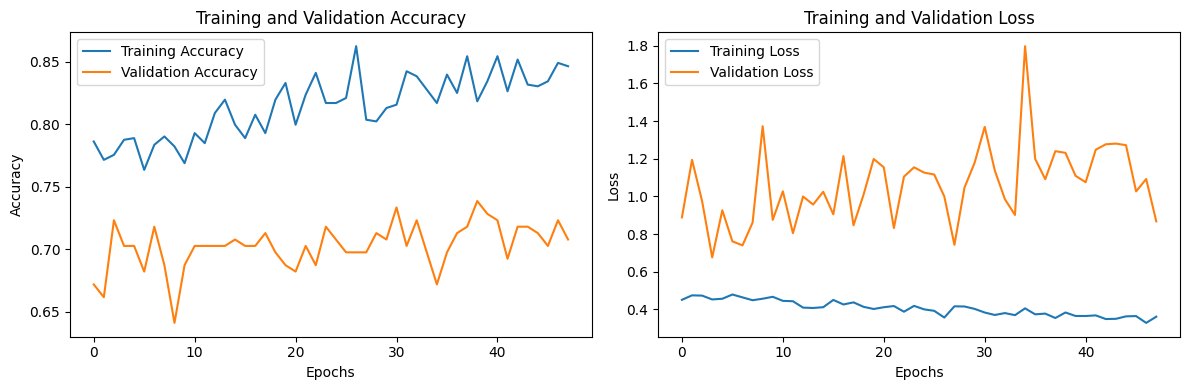

In [35]:
# Plot training and validation accuracy and loss
def plot_training_history(history):
    # Accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)


In [36]:
model.save('ai_image_detection_model.h5')

In [39]:
def load_and_preprocess_single_image(image_path):
    img = cv2.imread(image_path)
    if img is not None:
        img = cv2.resize(img, (64, 64))  # Resize to 64x64 pixels
        img = img.astype('float32') / 255.0  # Normalize pixel values to [0, 1]
        return img
    else:
        print(f"Error loading image: {image_path}")
        return None

# Specify the path to your image
image_path = 'C:/Users/deepa/OneDrive/Desktop/STGI02/testai.jpeg'  # Change this to your image path
test_image = load_and_preprocess_single_image(image_path)


1/1 [==============================] - 0s 33ms/step


Prediction for the uploaded image: AI Generated


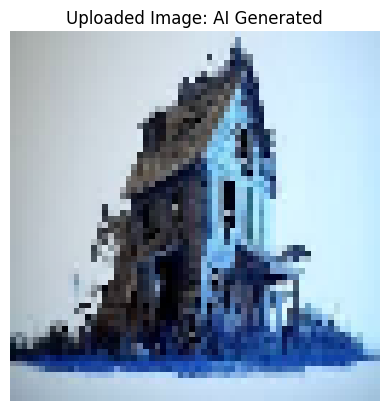

In [40]:
if test_image is not None:
    # Add an extra dimension to the image for batch size
    test_image = np.expand_dims(test_image, axis=0)

    # Make prediction
    prediction = cnn_model.predict(test_image)
    predicted_class = (prediction > 0.5).astype(int)

    # Display the result
    result = 'AI Generated' if predicted_class[0][0] == 1 else 'Real'
    print(f"Prediction for the uploaded image: {result}")

    # Optionally visualize the uploaded image
    plt.imshow(test_image[0])  # Display the image
    plt.title(f"Uploaded Image: {result}")
    plt.axis('off')
    plt.show()
